# Holiday Effect Strategy - Data Exploration

Analyze market behavior around major holidays (Thanksgiving, Christmas, New Year).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 1. Load Market Data

In [2]:
# Fetch SPY data
spy = yf.download('SPY', start='2010-01-01', end='2024-12-31')
spy['Returns'] = spy['Close'].pct_change()

print(f"Data range: {spy.index[0]} to {spy.index[-1]}")
print(f"Total trading days: {len(spy)}")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Data range: 2010-01-04 00:00:00 to 2024-12-30 00:00:00
Total trading days: 3773


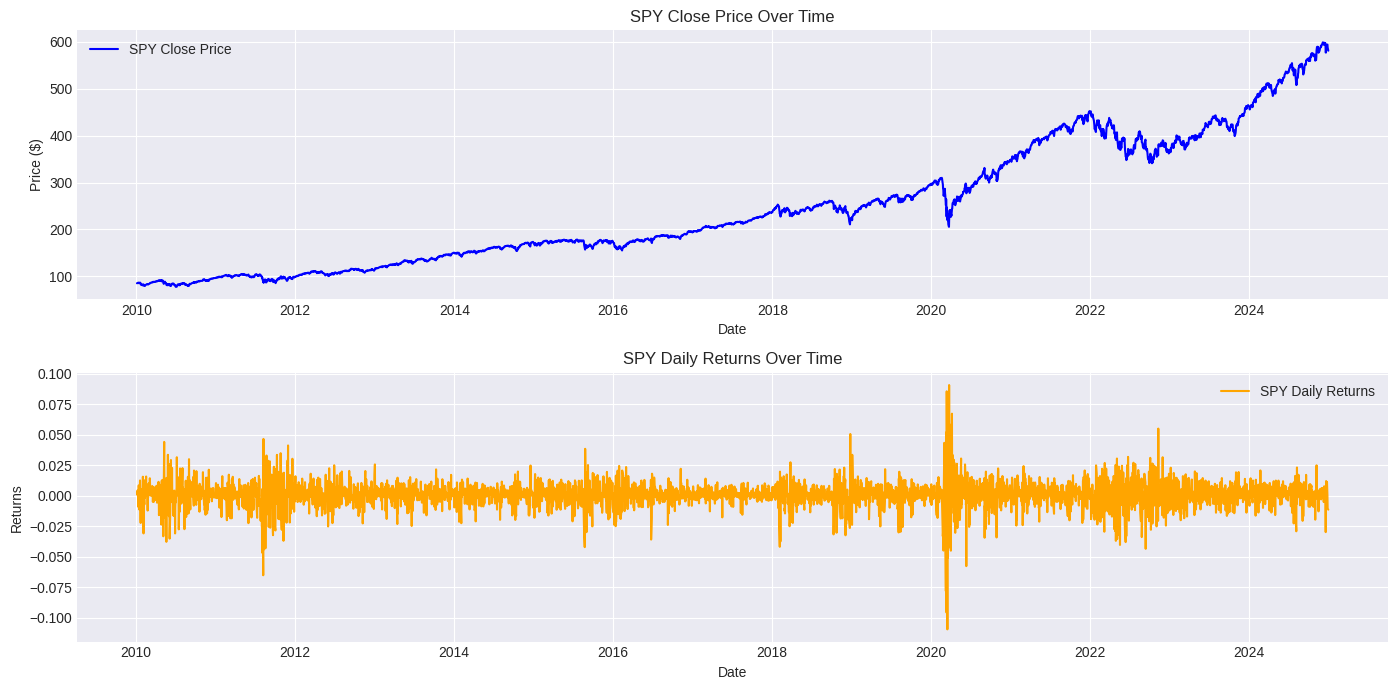

In [3]:
#visualize spy data
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(spy['Close'], label='SPY Close Price', color='blue')
plt.title('SPY Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(spy['Returns'], label='SPY Daily Returns', color='orange')
plt.title('SPY Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.tight_layout()
plt.show()

## 2. Define Holiday Periods

In [4]:
# Define major US holidays
def get_holiday_dates(start_year, end_year):
    holidays = []
    for year in range(start_year, end_year + 1):
        # Thanksgiving (4th Thursday of November)
        nov_1 = pd.Timestamp(f'{year}-11-01')
        thanksgiving = nov_1 + pd.DateOffset(days=(3 - nov_1.weekday()) % 7 + 21)
        holidays.append(('Thanksgiving', thanksgiving))
        
        # Christmas
        holidays.append(('Christmas', pd.Timestamp(f'{year}-12-25')))
        
        # New Year
        holidays.append(('New Year', pd.Timestamp(f'{year}-01-01')))
    
    return pd.DataFrame(holidays, columns=['Holiday', 'Date'])

holidays = get_holiday_dates(2010, 2024)
print(f"Total holidays: {len(holidays)}")
holidays.head(10)

Total holidays: 45


,Holiday,Date
0,Thanksgiving,2010-11-25
1,Christmas,2010-12-25
2,New Year,2010-01-01
3,Thanksgiving,2011-11-24
4,Christmas,2011-12-25
5,New Year,2011-01-01
6,Thanksgiving,2012-11-22
7,Christmas,2012-12-25
8,New Year,2012-01-01
9,Thanksgiving,2013-11-28


## 3. Analyze Pre-Holiday Returns

In [5]:
# Calculate returns around holidays
def get_holiday_returns(spy_data, holiday_dates, days_before=5, days_after=5):
    results = []
    
    for _, row in holiday_dates.iterrows():
        holiday_date = row['Date']
        holiday_name = row['Holiday']
        
        # Get trading days around holiday
        window_start = holiday_date - pd.Timedelta(days=days_before + 5)
        window_end = holiday_date + pd.Timedelta(days=days_after + 5)
        
        window_data = spy_data.loc[window_start:window_end]
        
        if len(window_data) > 0:
            # Find closest trading day to holiday
            closest_idx = window_data.index.get_indexer([holiday_date], method='nearest')[0]
            
            if closest_idx >= days_before and closest_idx + days_after < len(window_data):
                pre_returns = window_data['Returns'].iloc[closest_idx - days_before:closest_idx].mean()
                post_returns = window_data['Returns'].iloc[closest_idx:closest_idx + days_after].mean()
                
                results.append({
                    'Holiday': holiday_name,
                    'Date': holiday_date,
                    'Pre_Holiday_Return': pre_returns,
                    'Post_Holiday_Return': post_returns
                })
    
    return pd.DataFrame(results)

holiday_returns = get_holiday_returns(spy, holidays)
holiday_returns.head()

,Holiday,Date,Pre_Holiday_Return,Post_Holiday_Return
0,Thanksgiving,2010-11-25,0.003387,0.003967
1,Christmas,2010-12-25,0.002301,0.000239
2,Thanksgiving,2011-11-24,-0.012391,0.014182
3,Christmas,2011-12-25,0.007861,0.001804
4,New Year,2011-01-01,-0.000095,0.002653


## 4. Statistical Analysis

In [6]:
# Group by holiday type
holiday_stats = holiday_returns.groupby('Holiday').agg({
    'Pre_Holiday_Return': ['mean', 'std', 'count'],
    'Post_Holiday_Return': ['mean', 'std']
})

print("Holiday Effect Statistics:")
print(holiday_stats)

# Compare to overall market
overall_mean = spy['Returns'].mean()
print(f"\nOverall market daily return: {overall_mean:.4%}")

Holiday Effect Statistics:
             Pre_Holiday_Return                 Post_Holiday_Return          
                           mean       std count                mean       std
Holiday                                                                      
Christmas              0.000465  0.005522    13            0.001939  0.003947
New Year               0.001199  0.002523    14            0.001184  0.004530
Thanksgiving           0.001285  0.004288    15            0.001770  0.004739

Overall market daily return: 0.0568%


## 5. Visualization

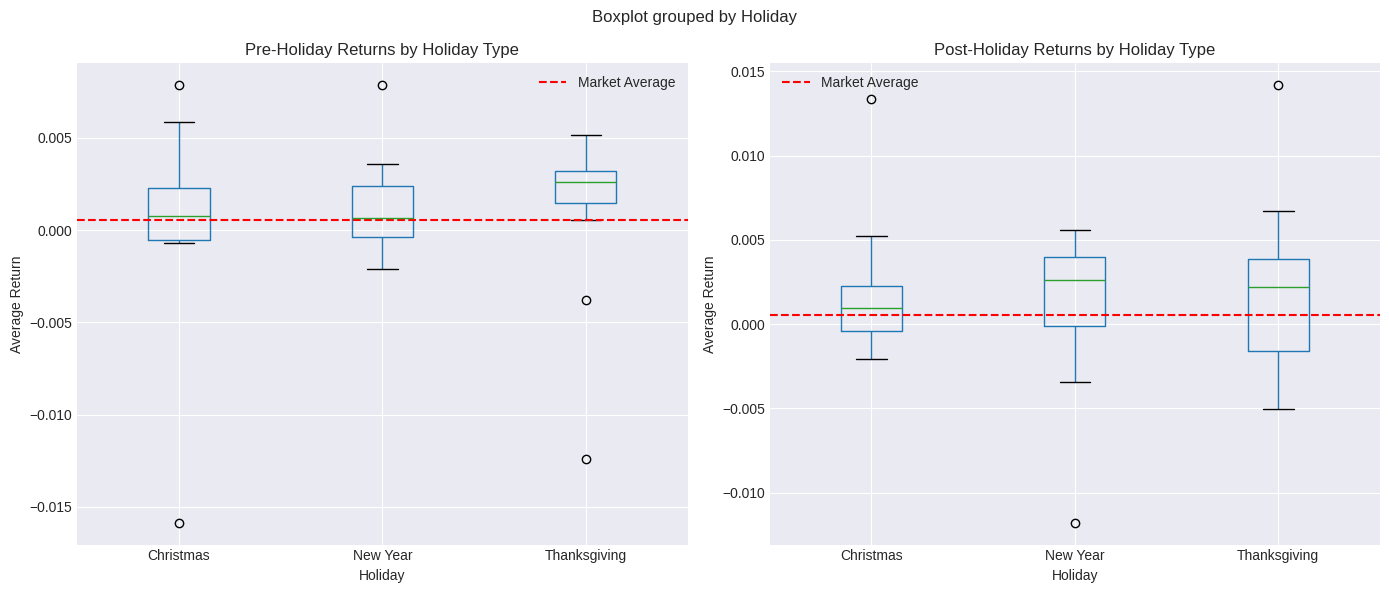

In [7]:
# Plot pre vs post holiday returns
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Pre-holiday returns
holiday_returns.boxplot(column='Pre_Holiday_Return', by='Holiday', ax=axes[0])
axes[0].set_title('Pre-Holiday Returns by Holiday Type')
axes[0].set_ylabel('Average Return')
axes[0].axhline(overall_mean, color='red', linestyle='--', label='Market Average')
axes[0].legend()

# Post-holiday returns
holiday_returns.boxplot(column='Post_Holiday_Return', by='Holiday', ax=axes[1])
axes[1].set_title('Post-Holiday Returns by Holiday Type')
axes[1].set_ylabel('Average Return')
axes[1].axhline(overall_mean, color='red', linestyle='--', label='Market Average')
axes[1].legend()

plt.tight_layout()
plt.show()